# 4. Analysis
At this stage, we have a good idea about the PKA simulation. However, we are mainly interested in the structural changes to the materials. In this chapter, we will analyze the structural and chemical changes to help us quantify the defects.

## 4.1 Copy files
- Copy "data.lmp" and "dump.lmp" from "3. PKA" folder.

In [1]:
from pathlib import Path
from shutil import copy
cwd = Path.cwd()
source = cwd.parent/'3. PKA'

copy(source/'data.lmp', cwd)
copy(source/'dump.lmp', cwd)

'c:\\Users\\fitbe\\OneDrive\\Desktop\\PKA Tutorial\\LAMMPS\\4. Analysis\\dump.lmp'

## 4.2 Structural changes
**Wigner-Seitz defect analysis** is typically used to quantify crystalline materials for Frenkel pairs (vacancy and interstitial).

A simple way is to open "dump.lmp" in OVITO software. Under `Add modification`, choose `Wigner-Seitz defect analysis`. You should see the number of vacancies and interstitials for each frame on the bottom-right corner. You should also find them under `Global Attributes` above the timeline. There is an option there to export to a text file for later use.

Alternatively, we can use OVITO Python. We will show how to do this.

In [2]:
# Import packages
from ovito.io import import_file
from ovito.modifiers import WignerSeitzAnalysisModifier as WSAM
import matplotlib.pyplot as plt

In [3]:
# Load the dump file
pipeline = import_file(location='dump.lmp', input_format='lammps/dump', multiple_frames=True)

# Append the Wigner-Seitz analysis modifier to the pipeline
pipeline.modifiers.append(WSAM())

# Create lists to store time and vacancy count
time = []
vacancy = []

# Compute for each frame
num_frames = pipeline.source.num_frames
for frame in range(num_frames):
    data = pipeline.compute(frame)
    time.append(data.attributes['Time'])
    vacancy.append(data.attributes['WignerSeitz.vacancy_count'])

Text(0, 0.5, 'Vacanct Count')

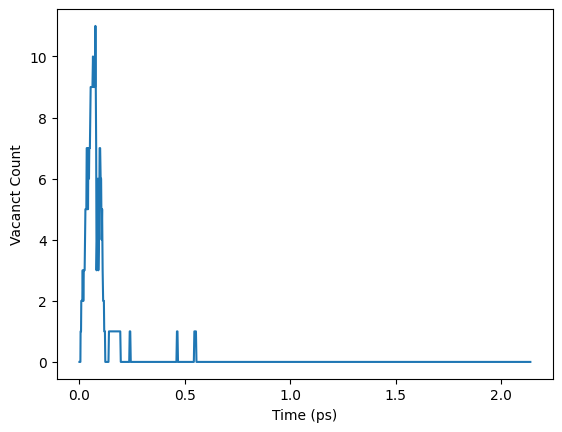

In [4]:
# Plot the vacancy count
plt.plot(time, vacancy)
plt.xlabel('Time (ps)')
plt.ylabel('Vacanct Count')

Vacancy count becomes 0 at the end means that likely the structural change is negligible for 30 eV carbon PKA. To demonstrate the effect of increasing potential energy, we can plot the number of "defective" atoms as we defined in the previous section, i.e., displacement greater than or equal to 0.2 Å.

In [5]:
# Import packages
from ovito.modifiers import ExpressionSelectionModifier as ESM

Text(0, 0.5, 'Defective Atom Count')

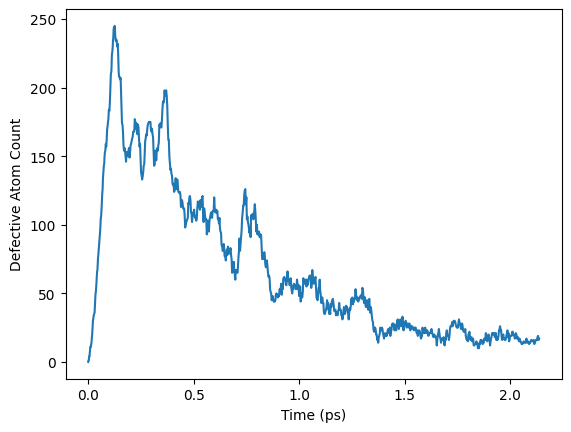

In [6]:
# Load the dump file
pipeline = import_file(location='dump.lmp', input_format='lammps/dump', multiple_frames=True)

# Select atoms with displacement >= 0.2
pipeline.modifiers.append(ESM(expression='c_disp_4_ >= 0.2'))

# Create list to store defective atom counts
disp = []

# Compute for each frame
for frame in range(num_frames):
    data = pipeline.compute(frame)
    disp.append(data.attributes['ExpressionSelection.count'])
    
# Plot the defective atom count
plt.plot(time, disp)
plt.xlabel('Time (ps)')
plt.ylabel('Defective Atom Count')

## 4.3. Chemical changes
Since we are dealing with polymeric system, likely there will be chemical changes such as small molecules produced, chain scissoring, and cross-linking.

First, we want to introduce a simple way to determine chain scissioring and cross-linking. That is counting the number of C-C bonds over time.

### 4.3.1. C-C bonds
The Van der Waals radius of carbon is 1.7. This is used as the cutoff distance.

In [7]:
# Import packages
from ovito.modifiers import CreateBondsModifier as CBM
from ovito.modifiers import SelectTypeModifier as STM
from ovito.modifiers import DeleteSelectedModifier as DSM

Text(0, 0.5, 'C-C Bond Count')

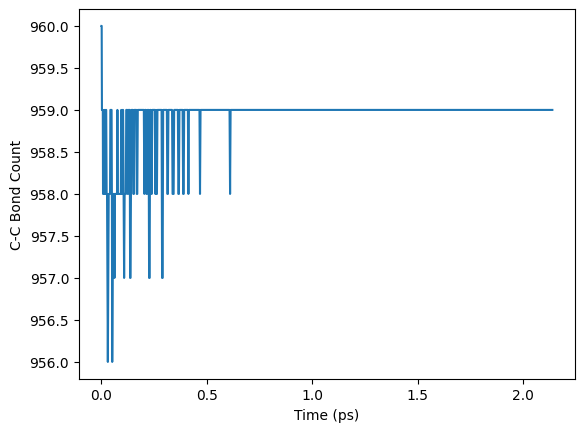

In [8]:
# Load the dump file
pipeline = import_file(location='dump.lmp', input_format='lammps/dump', multiple_frames=True)

# Select and delete H atoms (type 2) and count C-C bonds over time
pipeline.modifiers.append(STM(types={2}))
pipeline.modifiers.append(DSM())
pipeline.modifiers.append(CBM(cutoff=1.7))

# Create list to store bond count
bond = []

# Compute for each frame
for frame in range(num_frames):
    data = pipeline.compute(frame)
    bond.append(data.attributes['CreateBonds.num_bonds'])
    
# Plot the bond count
plt.plot(time, bond)
plt.xlabel('Time (ps)')
plt.ylabel('C-C Bond Count')

At the end, we find that 1 C-C broken bond. This means chain scissoring takes place. Next, we will perform species analysis. This can be easily done by invoking `fix reaxff/species` by taking advantage of `ReaxFF` module in LAMMPS.

### 4.3.2. Species
- Copy "ffield.reax.cho" from local "Potential" folder from LAMMPS. This force field is famous for C-H-O systems under combustion. You can read more about ReaxFF force field at https://doi.org/10.1021/jp709896w.

#### 4.3.2.1 Change atom_style of "data.lmp" from "atomic" to "charge"

ReaxFF needs "charge" while our previous simulation uses "atomic".
We use OVITO Python to convert it.

In [9]:
# Import packages
from ovito.io import export_file

In [10]:
# Load the data
pipeline = import_file(location='data.lmp', input_format='lammps/data')

# Export the data
export_file(data=pipeline, file='data.lmp', format='lammps/data', atom_style='charge')

#### 4.3.3.2. Load dump file
- Loading dump file is the same as before. We just define the frames we want and invoke `pipleine.compute`.
- We want to find out the timestep for the initial and final frames.
- Then we can use `read_dump` in LAMMPS to import the structure.

In [11]:
# Load the dump file
pipeline = import_file(location='dump.lmp', input_format='lammps/dump', multiple_frames=True)

# We only need the first and last frame
timestep = []
frames = [0, num_frames-1]
for frame in frames:
    data = pipeline.compute(frame)
    timestep.append(data.attributes['Timestep'])

#### 4.3.2.3. Input file for LAMMPS
- For structure, we first use `read_data` to load simulation setup such as atom type, mass, box size, etc. Then we use `read_dump` to load "dump.lmp". `replace no purge yes add yes` means that we delete existing atoms before loading "dump.lmp'.
- For force field, ReaxFF is similar to AIREBO. You should find it easy to understand. `checkqeq no` suppresses the need to check for charge equilibrium, which is needed if we want to actually run simulations such as energy minimization.
- For simulation, `fix reaxff/species` is invoked to export species to "species.lmp". `element` defines the names of the atom types.

In [12]:
%%writefile in.lmp
#---------- Initization ----------#
units metal
dimension 3
boundary p p f      # change z boundary to f for non-periodic, so that chain-scission can be detected
atom_style charge

#---------- structure ----------#
read_data data.lmp
read_dump dump.lmp ${timestep} x y z replace no purge yes add yes

#---------- Force Field ----------#
pair_style reaxff NULL checkqeq no
pair_coeff * * ffield.reax.cho C H

#---------- Simulation ----------#
fix 1 all reaxff/species 1 1 1 species.lmp element C H

run 1
#---------- End ----------#

Overwriting in.lmp


#### 4.3.2.4. Run LAMMPS

We first run for the initial frame to make sure the code works.

In [13]:
!lmp -i in.lmp -l log.lmp -v timestep 0

LAMMPS (2 Aug 2023 - Update 1)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
Loaded 1 plugins from C:\Users\fitbe\AppData\Local\LAMMPS 64-bit 2Aug2023 with GUI\plugins
Reading data file ...
  orthogonal box = (0 0 0) to (27.242954 28.197066 25.984337)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  2880 atoms
  reading velocities ...
  2880 velocities
  read_data CPU = 0.027 seconds
Scanning dump file ...
Reading snapshot from dump file ...
  orthogonal box = (0 0 0) to (27.242954 28.197066 25.984337)
  2880 atoms before read
  2880 atoms in snapshot
  2880 atoms purged
  0 atoms replaced
  0 atoms trimmed
  2880 atoms added
  2880 atoms after read
Reading potential file ffield.reax.cho with DATE: 2011-02-18

CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE

Your simulation uses code contributions which should be cited:
- pair reaxff command: doi:10.1016/j.parco.2011.08.005
The log file l

Let's open the "species.lmp" to see it makes sense. The polymer chain is in the z-direction and each unit cell should give us 2 chains and C2H4 for each chain. We have 4x6x10 unit cells in x, y, z directions. In total, there should be 48 chains and each chain is C20H40.

In [14]:
!type species.lmp

#  Timestep    No_Moles    No_Specs      C20H40
          1          48           1          48


Then we demonstrate how to run LAMMPS for a loop. This is useful to read multiple dump frames.

In [15]:
# Import packages
import subprocess 
import shlex

In [16]:
# Create a new text file to store the species information for all frames
f = open('species.all.lmp', 'w')

# Run the LAMMPS simulation for a loop
for i in timestep:
    command_line = f'lmp -i in.lmp -l log.lmp -v timestep {i}'
    args = shlex.split(command_line)
    p = subprocess.Popen(args)
    p.wait()
    
    # Read 'species.lmp' and write it to 'species.all.lmp'
    with open('species.lmp') as f1:
        lines = f1.readlines()
    for line in lines:
        if 'Timestep' in line:
            pass
        else:
            temp = line.split()
            old = temp[0]
            new = str(int(old) - 1)
            temp[0] = new
            line = '\t'.join(temp)
        f.write(line)
    f.write('\n')

# Close the file
f.close()

Let's open the "species.all.lmp" to see the chemical changes. The broken bonds are shown here clearly.

In [17]:
!type species.all.lmp

#  Timestep    No_Moles    No_Specs      C20H40
0	48	1	48
#  Timestep    No_Moles    No_Specs      C20H40      C12H24       C8H16
4405	49	3	47	1	1


## 4.4 Summary
The approach should be applicable to lots of materials systems given you have good force field.

If you want to play around with the PKA simulation, you can increase the PKA kinetic energy with a larger simulation box to see how it affects the defects. We expect more defects with higher PKA energy. What about choosing a hydrogen PKA? What about PKA direction?

As our simulation size increases, our computational time increases dramatically. Instead of using local laptop, we need to run on supercomputing clusters. For the next chapter, we will run the same PKA simulation on [PACE](https://pace.gatech.edu/) at Georgia Tech.